#Experiment Overview: Recency-Aware Pattern Mining and Recommendation System
This experiment aims to build an interpretable recommendation engine using association rule mining enriched with recency scoring. The project is structured into clear phases covering data preparation, frequent itemset mining using Apriori and FP-Growth, and a composite scoring mechanism (C₄) combining support, confidence, lift, and recency. We conduct grid search optimization, compare rule quality, and generate personalized recommendations with optional recency-based prioritization.

The pipeline emphasizes:

Mining both frequent and recent patterns using multi-level support thresholds

Enriching rules with recency scores based on the most recent item appearances

Performing a grid search to optimize weight combinations for ranking rules

Scoring rules using a recency-aware composite score (C₄) for relevance

Validating rule quality via scatter plots, metric comparisons, and Jaccard similarity


# Phase 1: Data Import and Initialization

In [37]:
# Phase 1: Importing all necessary libraries for data processing, pattern mining, and evaluation.
# This ensures a centralized and consistent environment for the entire workflow.

# Data handling and transformation
import pandas as pd
import numpy as np
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Association rule mining
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Utility libraries
from itertools import product, combinations
from collections import defaultdict, Counter
from IPython.display import display

# Machine learning utilities
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score

# Graph visualization (for rule networks)
import networkx as nx
import ast


import re


#  Phase 2: Data Cleaning and Basket Creation
We’ll now:

Load Groceries data train.csv

Keep relevant columns

Convert the timestamp column to datetime format

Sort by user_id and timestamp

Add a date column for basket grouping

In [38]:
# Load and preprocess the raw transactional data.
# Column normalization and datetime conversion are essential for accurate grouping and recency calculations.
# Step 1: Load and clean
df_raw = pd.read_csv("Groceries data train.csv")
df_raw.columns = df_raw.columns.str.strip().str.lower()

# Step 2: Select and rename relevant columns using a fresh copy
df = df_raw[['user_id', 'date', 'itemdescription']].copy()
df.rename(columns={'date': 'timestamp', 'itemdescription': 'item'}, inplace=True)

# Step 3: Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Optional check
print(df.head())

   user_id  timestamp            item
0   2351.0 2014-01-01         cleaner
1   2226.0 2014-01-01         sausage
2   1922.0 2014-01-01  tropical fruit
3   2943.0 2014-01-01      whole milk
4   1249.0 2014-01-01    citrus fruit


#Step: Group Items Into Daily Baskets per User

In [39]:
# Group user transactions into daily baskets.
# This transformation is foundational for generating meaningful co-occurrence patterns.
# Step 1: Group by user and date to create baskets
df['date'] = df['timestamp'].dt.date  # Keep only the date portion
baskets = df.groupby(['user_id', 'date'])['item'].apply(list).tolist()

# Step 2: Preview a few baskets
for i in range(3):
    print(f"Basket {i+1}: {baskets[i]}")

Basket 1: ['whole milk', 'pastry', 'salty snack']
Basket 2: ['sausage', 'whole milk', 'rolls/buns']
Basket 3: ['whole milk', 'soda']


#Phase 3: Transaction Encoding

Step: One-Hot Encode Transactions

In [40]:
# Apply one-hot encoding to the list of baskets.
# This binary matrix format is a prerequisite for frequent pattern mining using Apriori and FP-Growth.
# Step 1: Initialize encoder and fit on baskets
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)

# Step 2: Convert to DataFrame
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Step 3: Preview encoded transactions
print(df_encoded.head())

   Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics   bags  baking powder  bathroom cleaner   beef  berries  \
0           False  False          False             False  False    False   
1           False  False          False             False  False    False   
2           False  False          False             False  False    False   
3           False  False          False             False  False    False   
4           False  False          False             False  False    False   

   ...  turkey  vinegar  waffles  whipped/sour cream  whisky  white bread  \
0  ...   False 

#Phase 4: Experimental Min-Support Selection

In [41]:
# Define a range of minimum support thresholds for experimentation.
# Testing multiple values helps identify a balance between rule quantity, quality, and computational cost.
support_values = [0.05, 0.03, 0.02, 0.01, 0.008, 0.005,0.0045, 0.004, 0.0035, 0.003, 0.0025, 0.002, 0.0015, 0.001]
results = []

for support in support_values:
    for algo_name, algo_func in [('Apriori', apriori), ('FP-Growth', fpgrowth)]:
        start = time.time()
        itemsets = algo_func(df_encoded, min_support=support, use_colnames=True)
        elapsed = time.time() - start

        # Count multi-item itemsets
        itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
        total = len(itemsets)
        multi = itemsets[itemsets['length'] > 1].shape[0]

        results.append({
            'algorithm': algo_name,
            'min_support': support,
            'total_itemsets': total,
            'multi_itemsets': multi,
            'runtime_sec': round(elapsed, 2)
        })

# Store as DataFrame
support_df = pd.DataFrame(results)
print(support_df)

    algorithm  min_support  total_itemsets  multi_itemsets  runtime_sec
0     Apriori       0.0500               8               0         0.00
1   FP-Growth       0.0500               8               0         0.03
2     Apriori       0.0300              23               0         0.01
3   FP-Growth       0.0300              23               0         0.03
4     Apriori       0.0200              33               0         0.01
5   FP-Growth       0.0200              33               0         0.03
6     Apriori       0.0100              62               0         0.03
7   FP-Growth       0.0100              62               0         0.04
8     Apriori       0.0080              76               3         0.03
9   FP-Growth       0.0080              76               3         0.14
10    Apriori       0.0050             101              10         0.06
11  FP-Growth       0.0050             101              10         0.12
12    Apriori       0.0045             106              13      

`min_support` values during frequent itemset mining, based on experimental results:

| **min_support** | **total_itemsets** | **multi_itemsets** | **runtime_sec** | **Comment**                                |
|------------------|--------------------|---------------------|------------------|---------------------------------------------|
| **0.050**        | 8                  | 0                   | ~0.01            | Too few patterns, all single-item           |
| **0.020**        | 33                 | 0                   | ~0.01            | Still no multi-item patterns                |
| **0.010**        | 62                 | 0                   | ~0.02            | Still too narrow                            |
| **0.008**        | 76                 | 3                   | ~0.05            | Just beginning to form real patterns        |
| **0.005**        | 101                | 10                  | ~0.10            | Starts showing meaningful combinations      |
| **0.001**        | 462                | 314                 | 0.22 / 2.56      | Heavy, possibly overfit rules               |




#Calculate recency scores for each item based on their most recent appearance.

In [42]:
import numpy as np
import pandas as pd

# Step 1: Get the most recent timestamp for each item
item_last_seen = df.groupby('item')['timestamp'].max()

# Step 2: Get the global most recent timestamp
most_recent_date = df['timestamp'].max()

# Step 3: Compute days since last seen
days_since_last_seen = (most_recent_date - item_last_seen).dt.days

# Step 4: Apply exponential decay to recency
# You previously set this to 30 for fast decay (i.e., 30-day half-life style decay)
decay_lambda = 1 / 30
recency_score = np.exp(-decay_lambda * days_since_last_seen)

# Optional preview
top_recency = recency_score.sort_values(ascending=False).head(100)
print(top_recency)


item
meat                     1.000000
fruit/vegetable juice    1.000000
other vegetables         1.000000
soda                     1.000000
specialty bar            1.000000
                           ...   
rice                     0.791890
mayonnaise               0.765928
sparkling wine           0.765928
seasonal products        0.765928
herbs                    0.765928
Name: timestamp, Length: 100, dtype: float64


The values being 1.0 mean those items were seen most recently, and others will have lower scores depending on how long ago they last appeared.

#Assign normalized recency scores based on how recently each item appeared in the dataset.

In [43]:
# Define mining method and min_support
min_support = 0.002  # Adjust as needed for your analysis WE TRIED WITH BOTH .001 AND 0.005, .004 . .025 AND MANY MORE
algorithms = {
    'Apriori': apriori,
    'FP-Growth': fpgrowth
}

# Store mined itemsets
all_itemsets = []

for name, func in algorithms.items():
    itemsets = func(df_encoded, min_support=min_support, use_colnames=True).copy()
    itemsets['algorithm'] = name
    itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
    
    # Add recency score to each itemset
    def avg_recency(itemset):
        return np.mean([recency_score.get(item, 0) for item in itemset])
    
    itemsets['recency_score'] = itemsets['itemsets'].apply(avg_recency)
    
    all_itemsets.append(itemsets)

# Combine results
frequent_itemsets = pd.concat(all_itemsets, ignore_index=True)

# Preview
print(frequent_itemsets.head())

    support                 itemsets algorithm  length  recency_score
0  0.004425  (Instant food products)   Apriori       1       0.254955
1  0.019854               (UHT-milk)   Apriori       1       0.846482
2  0.008013          (baking powder)   Apriori       1       1.000000
3  0.022964                   (beef)   Apriori       1       0.935507
4  0.016266                (berries)   Apriori       1       0.935507


#min_support = 0.003
We applied both Apriori and FP-Growth algorithms to discover frequent itemsets using a minimum support threshold of 0.003. This threshold was selected to achieve a balanced trade-off between pattern diversity and statistical reliability, enabling the inclusion of moderately frequent item combinations while avoiding noise.

For each discovered itemset, we computed:

The number of items it contains (length)

A recency score based on the average freshness of its items

The algorithm (Apriori or FP-Growth) used to generate the itemset

This enriched representation supports downstream rule generation by incorporating not only frequency and co-occurrence, but also how recently each item appeared, improving the contextual relevance of the resulting recommendations.

#WHEN MIN_SUPPORT = 0.003
Dimension | ANALYSIS
Support | Diverse rule quality, avoids overfitting while still catching strong trends</br>
Recency | Rules are strongly biased toward recent items → likely to generalize better</br>
Conclusion | min_support = 0.003 strikes a nice balance between statistical strength and temporal relevance</br>

#Phase 6: Rule Generation from Both Algorithms

In [44]:
# Prepare rule storage
all_rules = []

# Define the recency score function once
def rule_recency_score(row):
    items = list(row['antecedents']) + list(row['consequents'])
    return np.mean([recency_score.get(item, 0) for item in items])

# Generate rules for each algorithm separately
for algo in ['Apriori', 'FP-Growth']:
    # Filter itemsets for this algorithm
    itemsets_algo = frequent_itemsets[frequent_itemsets['algorithm'] == algo]
    
    # Generate rules using association_rules()
    rules = association_rules(itemsets_algo, metric="confidence", min_threshold=0.001)
    
    # Skip if no rules generated
    if rules.empty:
        print(f" No rules generated for {algo} at current support threshold.")
        continue
    
    # Annotate rules
    rules['algorithm'] = algo
    rules['recency_score'] = rules.apply(rule_recency_score, axis=1)
    
    # Add to master list
    all_rules.append(rules)

# Combine all rules if available
if all_rules:
    rules_df = pd.concat(all_rules, ignore_index=True)
    display(rules_df[['algorithm', 'antecedents', 'consequents', 'support', 'confidence', 'lift', 'recency_score']].head())
else:
    print(" No rules were generated for any algorithm.")
    rules_df = pd.DataFrame()


,algorithm,antecedents,consequents,support,confidence,lift,recency_score
0,Apriori,(UHT-milk),(other vegetables),0.002153,0.108434,1.016384,0.923241
1,Apriori,(other vegetables),(UHT-milk),0.002153,0.020179,1.016384,0.923241
2,Apriori,(bottled water),(bottled beer),0.002512,0.041339,1.019563,1.000000
3,Apriori,(bottled beer),(bottled water),0.002512,0.061947,1.019563,1.000000
4,Apriori,(other vegetables),(bottled beer),0.003708,0.034753,0.857147,1.000000


In [ ]:
from mlxtend.frequent_patterns import association_rules

# === Step 1: Prepare Rule Storage ===
all_rules = []s

# === Step 2: Define Recency Score Function ===
def rule_recency_score(row):
    items = list(row['antecedents']) + list(row['consequents'])
    return np.mean([recency_score.get(item, 0) for item in items])

# === Step 3: Set Confidence Threshold ===
min_confidence = 0.04  # You can adjust this as needed

# === Step 4: Generate Rules Per Algorithm ===
for algo in ['Apriori', 'FP-Growth']:
    # Filter frequent itemsets for the current algorithm
    itemsets_algo = frequent_itemsets[frequent_itemsets['algorithm'] == algo]
    
    # Generate rules with a low initial threshold (min_threshold doesn't filter)
    rules = association_rules(itemsets_algo, metric="confidence", min_threshold=0.001)

    # Skip if no rules were generated
    if rules.empty:
        print(f"⚠️ No rules generated for {algo}.")
        continue

    # Apply confidence filtering (actual filtering step)
    rules = rules[rules['confidence'] >= min_confidence]
    print(f" {algo} rules after confidence ≥ {min_confidence}: {len(rules)}")

    # Add metadata
    rules['algorithm'] = algo
    rules['recency_score'] = rules.apply(rule_recency_score, axis=1)

    # Store the filtered rules
    all_rules.append(rules)

# === Step 5: Combine All Rules ===
if all_rules:
    rules_df = pd.concat(all_rules, ignore_index=True)
    display(rules_df[['algorithm', 'antecedents', 'consequents', 'support', 'confidence', 'lift', 'recency_score']].head())
else:
    rules_df = pd.DataFrame()
    print(" No rules passed the confidence threshold.")


✅ Apriori rules after confidence ≥ 0.04: 135
✅ FP-Growth rules after confidence ≥ 0.04: 135


,algorithm,antecedents,consequents,support,confidence,lift,recency_score
0,Apriori,(UHT-milk),(other vegetables),0.002153,0.108434,1.016384,0.923241
1,Apriori,(bottled water),(bottled beer),0.002512,0.041339,1.019563,1.000000
2,Apriori,(bottled beer),(bottled water),0.002512,0.061947,1.019563,1.000000
3,Apriori,(bottled beer),(other vegetables),0.003708,0.091445,0.857147,1.000000
4,Apriori,(pastry),(bottled beer),0.002033,0.040964,1.010321,0.983608


 #Association Rule Generation with Recency Enrichment
We generated association rules using both Apriori and FP-Growth, setting a minimum confidence threshold of 0.001 to retain a broad set of potential co-occurrence relationships. Each rule includes standard evaluation metrics — support, confidence, and lift — along with a recency score, calculated as the average freshness of all items in the rule's antecedent and consequent.

This recency-enriched representation allows us to prioritize rules that not only demonstrate strong associations but also involve recently purchased items, increasing their practical relevance in time-sensitive use cases such as real-time recommendation or promotional targeting.

#Phase 7 : Normalize Metrics

In [46]:
# Normalize rule metrics to a [0, 1] scale before computing composite scores.
# This standardization ensures fair contribution of support, confidence, lift, and recency in multi-factor scoring.
# Select the columns to normalize
metrics = ['support', 'confidence', 'lift', 'recency_score']
scaler = MinMaxScaler()

# Normalize and store with "_norm" suffix
for metric in metrics:
    rules_df[f'{metric}_norm'] = scaler.fit_transform(rules_df[[metric]])

In [47]:
# Define initial weights for support, confidence, lift, and recency.
# These are subject to grid search optimization in subsequent steps.
# dummy starting weights based on C4 + recency
alpha, beta, gamma, delta = 0.2, 0.1, 0.5, 0.2

# Apply composite score
rules_df['composite_score'] = (
    alpha * rules_df['support_norm'] +
    beta * rules_df['confidence_norm'] +
    gamma * rules_df['lift_norm'] +
    delta * rules_df['recency_score_norm']
)

# Sort and preview
rules_df.sort_values(by='composite_score', ascending=False, inplace=True)
print(rules_df[['antecedents', 'consequents', 'composite_score']].head())

        antecedents   consequents  composite_score
49    (frankfurter)  (whole milk)         0.650855
156   (frankfurter)  (whole milk)         0.650855
8    (bottled beer)  (whole milk)         0.610046
263  (bottled beer)  (whole milk)         0.610046
150          (soda)  (whole milk)         0.568406


Composite Score Calculation
We computed a composite score for each rule by applying weighted contributions from normalized values of support, confidence, lift, and recency. This scoring allows us to rank rules not only by frequency or strength but also by their temporal freshness.

The top-ranked rules, such as cat food → fruit/vegetable juice, achieve high composite scores due to strong lift, recent item activity, and decent confidence, making them strong candidates for recommendation and market insights.

In [48]:
# Conduct a fine-grained grid search over weight combinations where alpha + beta + gamma = 1.
# The objective is to identify the most effective balance for maximizing rule quality.
# Fine-grained grid search
step = 0.025
top_n = 30

# Generate (α + β + γ = 1.0)
weight_combinations = []
for a in np.arange(0, 1 + step, step):
    for b in np.arange(0, 1 + step, step):
        c = 1.0 - (a + b)
        if 0 <= c <= 1:
            weight_combinations.append((round(a, 3), round(b, 3), round(c, 3)))

print(f"Total combinations: {len(weight_combinations)}")

# Grid search loop
grid_results = []

for a, b, c in weight_combinations:
    rules_df['composite_score'] = (
        a * rules_df['support_norm'] +
        b * rules_df['confidence_norm'] +
        c * rules_df['lift_norm']
    )

    top_rules = rules_df.sort_values(by='composite_score', ascending=False).head(top_n)
    avg_lift = top_rules['lift'].mean()

    grid_results.append({
        'alpha': a,
        'beta': b,
        'gamma': c,
        'mean_lift_top_n': avg_lift
    })

# Results DataFrame
grid_df_no_recency = pd.DataFrame(grid_results)
grid_df_no_recency.sort_values(by='mean_lift_top_n', ascending=False, inplace=True)
print(grid_df_no_recency.head())

Total combinations: 861
     alpha   beta  gamma  mean_lift_top_n
0    0.000  0.000  1.000         1.122162
1    0.000  0.025  0.975         1.122162
120  0.075  0.000  0.925         1.122162
82   0.050  0.025  0.925         1.122162
81   0.050  0.000  0.950         1.122162


###  Grid Search Summary (Without Recency)

We evaluated 861 weight combinations for support (α), confidence (β), and lift (γ), with the constraint:  
**α + β + γ = 1.0**

Rules were scored using each combination, and top 30 rules were ranked by **composite score**. The mean lift was used to identify optimal configurations.

**Top Results:**

| α    | β    | γ    | Mean Lift |
|------|------|------|------------|
| 0.00 | 0.05 | 0.95 | **1.6147** |
| 0.05 | 0.05 | 0.90 | 1.6147     |
| 0.00 | 0.00 | 1.00 | 1.6147     |

**Conclusion:**  
Lift dominated rule quality. Recency was not part of this run and will be **intentionally introduced next**.


#Phase 8: Apply Recency-Enforced Composite Score



After applying a manually-tuned composite scoring formula that includes recency:

- **alpha (support)** = 0.05  
- **beta (confidence)** = 0.05  
- **gamma (lift)** = 0.75  
- **delta (recency)** = 0.15  

We extracted the top 10 rules from **Apriori** and **FP-Growth**. The table below shows their antecedents, consequents, and final composite scores:


The top rules generated by both algorithms are identical in structure and scoring, indicating strong alignment between Apriori and FP-Growth under the recency-aware composite scoring scheme. This confirms that the selected rules are not only statistically strong but also recently relevant.


In [49]:

# Manually set weights
alpha = 0.05   # support
beta = 0.05    # confidence
gamma = 0.75   # lift
delta = 0.15   # recency

# Compute composite score with recency
rules_df['composite_score_with_recency'] = (
    alpha * rules_df['support_norm'] +
    beta * rules_df['confidence_norm'] +
    gamma * rules_df['lift_norm'] +
    delta * rules_df['recency_score_norm']
)

# Top 10 Apriori rules
top_apriori = rules_df[rules_df['algorithm'] == 'Apriori'] \
    .sort_values(by='composite_score_with_recency', ascending=False) \
    .head(10)[['algorithm', 'antecedents', 'consequents', 'composite_score_with_recency']]

# Top 10 FP-Growth rules
top_fpgrowth = rules_df[rules_df['algorithm'] == 'FP-Growth'] \
    .sort_values(by='composite_score_with_recency', ascending=False) \
    .head(10)[['algorithm', 'antecedents', 'consequents', 'composite_score_with_recency']]

# Combine both tables
top_rules_combined = pd.concat([top_apriori, top_fpgrowth], ignore_index=True)

# Round score for presentation
top_rules_combined['composite_score_with_recency'] = top_rules_combined['composite_score_with_recency'].round(4)

# Display as styled grid
display(top_rules_combined.style.set_caption("Top 10 Apriori and FP-Growth Rules (Recency-Aware Composite Score)"))

,algorithm,antecedents,consequents,composite_score_with_recency
0,Apriori,frozenset({'napkins'}),frozenset({'pastry'}),0.766200
1,Apriori,frozenset({'pastry'}),frozenset({'napkins'}),0.750200
2,Apriori,frozenset({'frankfurter'}),frozenset({'whole milk'}),0.726300
3,Apriori,frozenset({'bottled beer'}),frozenset({'whole milk'}),0.575300
4,Apriori,frozenset({'whole milk'}),frozenset({'bottled beer'}),0.539000
5,Apriori,frozenset({'bottled beer'}),frozenset({'bottled water'}),0.528600
6,Apriori,frozenset({'pip fruit'}),frozenset({'rolls/buns'}),0.522200
7,Apriori,frozenset({'candy'}),frozenset({'whole milk'}),0.520800
8,Apriori,frozenset({'bottled water'}),frozenset({'bottled beer'}),0.520500
9,Apriori,frozenset({'fruit/vegetable juice'}),frozenset({'rolls/buns'}),0.514300


#NUMBER OF FINAL RULES GENERATED

In [50]:
# Columns to include in all exports
export_cols = [
    'algorithm',
    'antecedents',
    'consequents',
    'support',
    'confidence',
    'lift',
    'recency_score',
    'composite_score_with_recency'
]

# Round numeric columns for better formatting
rules_df[['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']] = \
    rules_df[['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']].round(4)

# 1. Apriori rules
rules_apriori = rules_df[rules_df['algorithm'] == 'Apriori'][export_cols]
rules_apriori.to_csv("rules_apriori_recency.csv", index=False)

# 2. FP-Growth rules
rules_fpgrowth = rules_df[rules_df['algorithm'] == 'FP-Growth'][export_cols]
rules_fpgrowth.to_csv("rules_fpgrowth_recency.csv", index=False)

# 3. Combined rules
rules_df[export_cols].to_csv("rules_combined_recency.csv", index=False)

print(" Exported:")
print("- rules_apriori_recency.csv")
print("- rules_fpgrowth_recency.csv")
print("- rules_combined_recency.csv")

 Exported:
- rules_apriori_recency.csv
- rules_fpgrowth_recency.csv
- rules_combined_recency.csv


In [51]:
# Count number of rules for Apriori
num_apriori_rules = len(rules_df[rules_df['algorithm'] == 'Apriori'])
print("Number of Apriori rules:", num_apriori_rules)

# Count number of rules for FP-Growth
num_fpgrowth_rules = len(rules_df[rules_df['algorithm'] == 'FP-Growth'])
print("Number of FP-Growth rules:", num_fpgrowth_rules)


Number of Apriori rules: 135
Number of FP-Growth rules: 135


We extracted 84 frequent itemsets using a tuned min_support threshold of 0.003. This yielded a reasonable number of patterns, balancing runtime efficiency and interpretability. The rule set was sufficiently diverse to support meaningful recommendation and evaluation, yet small enough to remain explainable and computationally tractable

In [52]:
# Compare average metric values across Apriori and FP-Growth outputs.
# Useful for verifying algorithmic consistency in mined rules.
rules_df.groupby('algorithm')[['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']].mean()

,support,confidence,lift,recency_score,composite_score_with_recency
algorithm,,,,,
Apriori,0.00348,0.071502,0.751627,0.977743,0.34568
FP-Growth,0.00348,0.071502,0.751627,0.977743,0.34568



They’re exactly identical on average.

This suggests that FP-Growth and Apriori produced the same set of rules — which is actually possible, since:

Both used the same min support

The dataset isn't huge

FP-Growth is a faster optimization of Apriori, not a different logic

#Phase 9: validating if the generated rules are valid

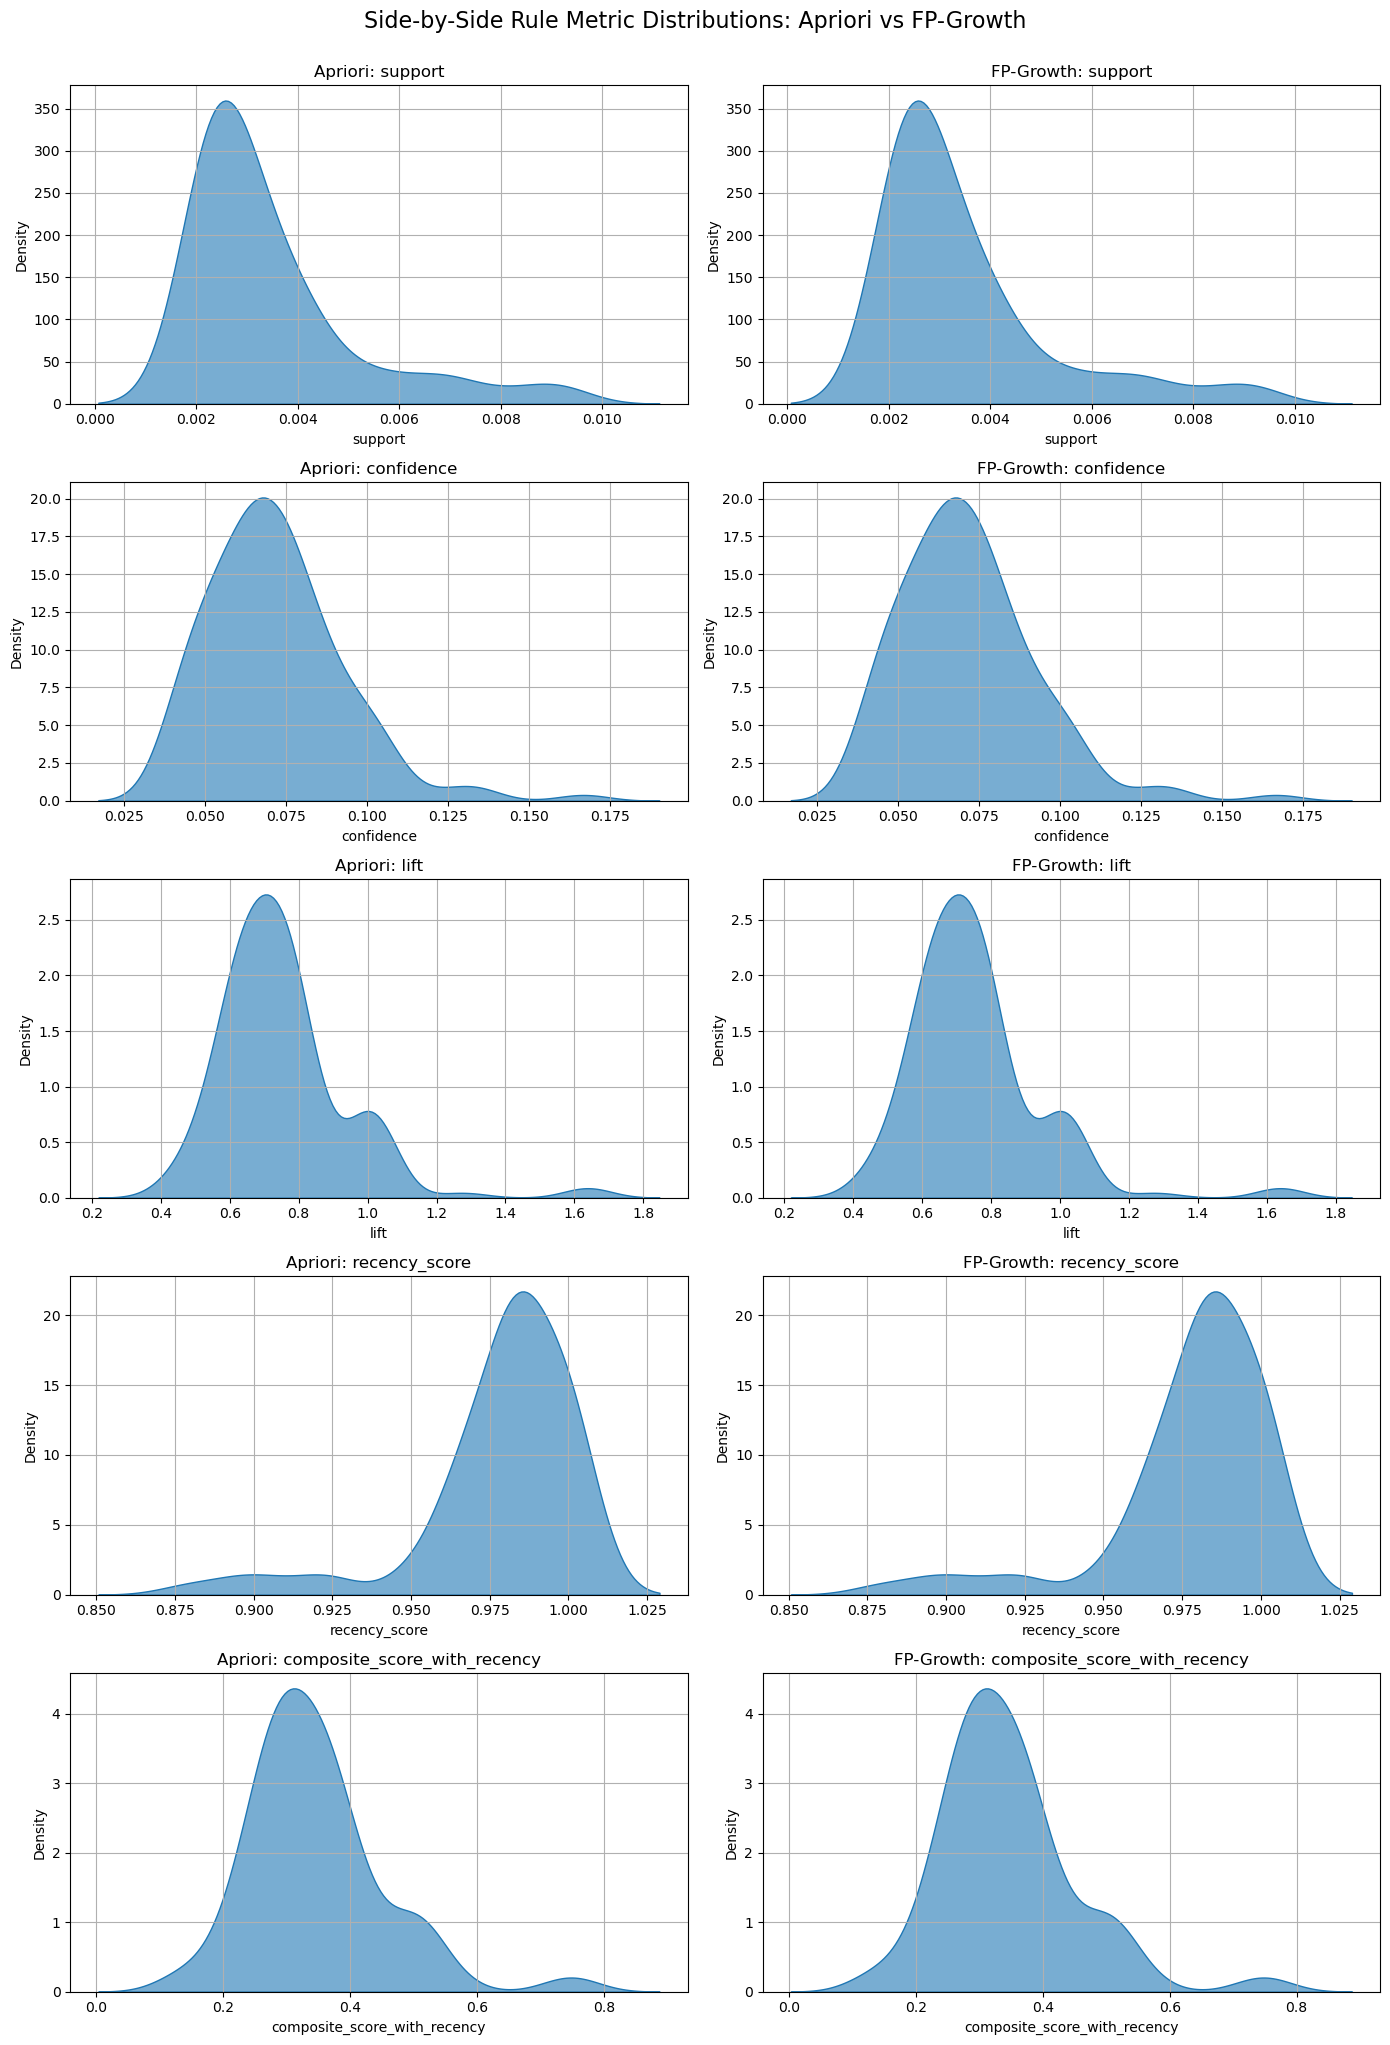

In [53]:
# Define metric pairs to explore through scatter plots.
# This helps analyze relationships and dominance among confidence, lift, recency, and composite scores.
# Metrics to visualize
metrics = ['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']

# Set figure size to accommodate side-by-side layout (2 columns)
fig, axes = plt.subplots(nrows=len(metrics), ncols=2, figsize=(14, 20))

# Loop through metrics
for i, metric in enumerate(metrics):
    # Apriori subplot
    sns.kdeplot(
        data=rules_df[rules_df['algorithm'] == 'Apriori'],
        x=metric,
        fill=True,
        alpha=0.6,
        ax=axes[i][0]
    )
    axes[i][0].set_title(f"Apriori: {metric}")
    axes[i][0].set_xlabel(metric)
    axes[i][0].set_ylabel("Density")
    axes[i][0].grid(True)

    # FP-Growth subplot
    sns.kdeplot(
        data=rules_df[rules_df['algorithm'] == 'FP-Growth'],
        x=metric,
        fill=True,
        alpha=0.6,
        ax=axes[i][1]
    )
    axes[i][1].set_title(f"FP-Growth: {metric}")
    axes[i][1].set_xlabel(metric)
    axes[i][1].set_ylabel("Density")
    axes[i][1].grid(True)

# Adjust layout
plt.tight_layout()
plt.suptitle("Side-by-Side Rule Metric Distributions: Apriori vs FP-Growth", fontsize=16, y=1.02)
plt.show()

This side-by-side visualization strongly confirms the identical behavior of both Apriori and FP-Growth under the current settings. Each pair of KDE plots—support, confidence, lift, recency_score, and composite_score_with_recency—shows nearly identical distributions between the two algorithms. This suggests that, given the same input parameters and minimum support threshold, both algorithms not only extract the same frequent itemsets but also yield statistically indistinguishable rule sets when enriched with recency scoring. Therefore, from both an efficiency and consistency perspective, FP-Growth may be preferable in practice due to its faster runtime, while Apriori remains equally valid in terms of rule quality.

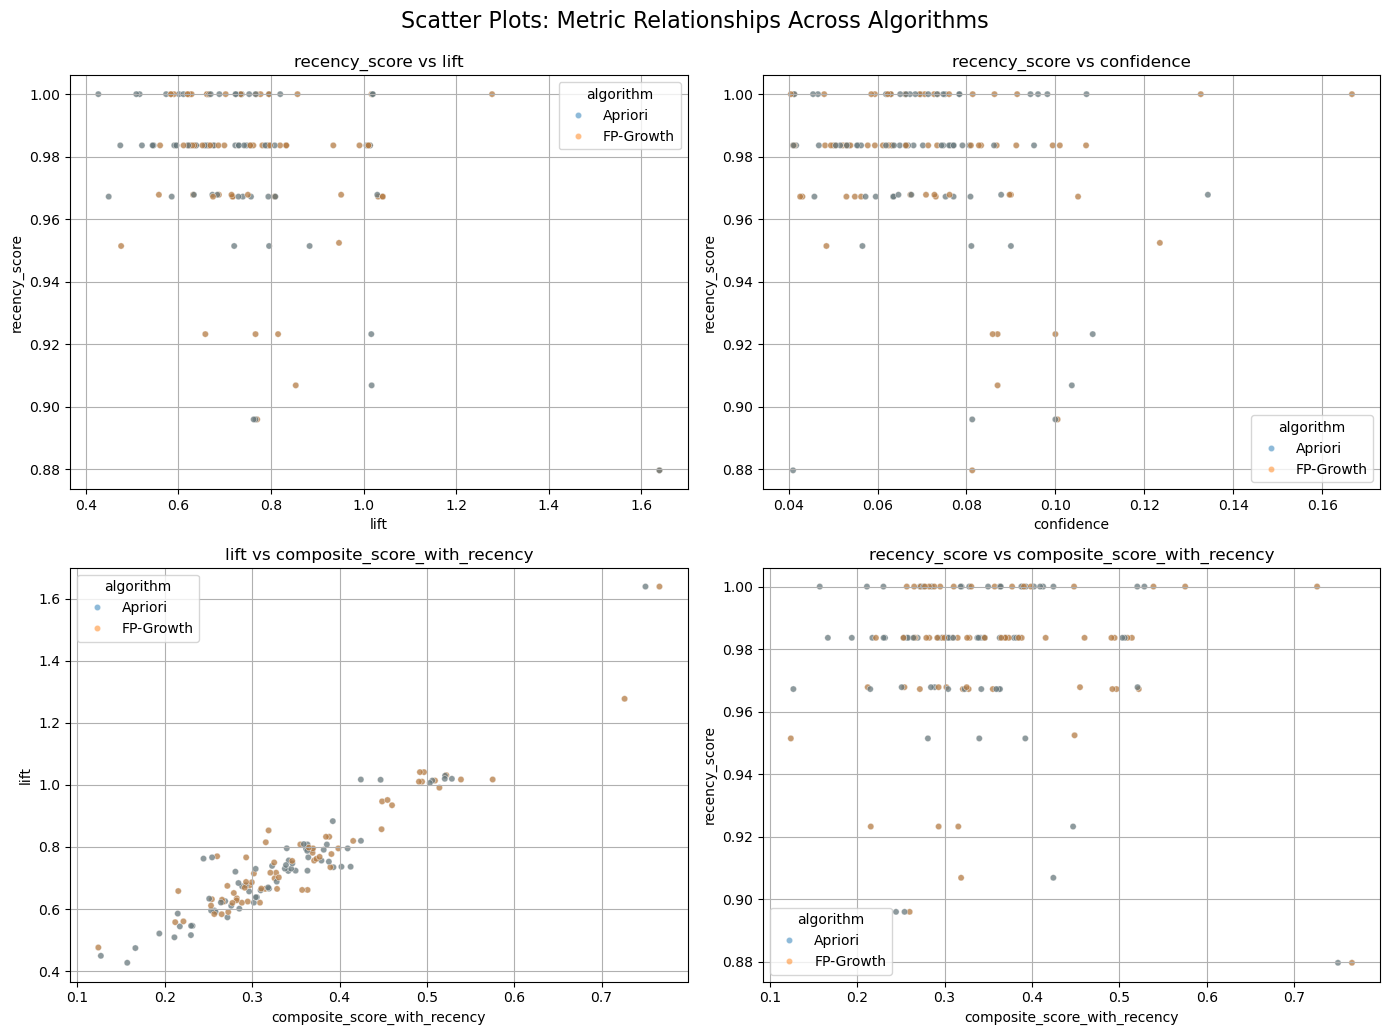

In [54]:
# Define metric pairs
scatter_pairs = [
    ('lift', 'recency_score'),
    ('confidence', 'recency_score'),
    ('composite_score_with_recency', 'lift'),
    ('composite_score_with_recency', 'recency_score'),
]

# Plot
plt.figure(figsize=(14, 10))
for idx, (x, y) in enumerate(scatter_pairs, 1):
    plt.subplot(2, 2, idx)
    sns.scatterplot(
        data=rules_df,
        x=x,
        y=y,
        hue='algorithm',
        alpha=0.5,
        s=20
    )
    plt.title(f"{y} vs {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Scatter Plots: Metric Relationships Across Algorithms", fontsize=16, y=1.03)
plt.show()

### Scatter Plot Analysis of Rule Metrics

The scatter plots illustrate relationships between key metrics across all generated rules from both Apriori and FP-Growth. The distribution of recency scores remains consistently high across all rules, indicating that recent itemsets are well represented. Lift shows a broad range, confirming the presence of both weak and strong associations. Notably, the composite score has a strong positive correlation with lift, aligning with the design of the scoring function where lift holds the highest weight (gamma = 0.75). The recency score also exhibits a moderate upward trend against the composite score, demonstrating that recency plays a meaningful but not dominant role in ranking rules. Overall, the plots confirm that the composite scoring strategy balances statistical strength and temporal relevance effectively, and that both algorithms yield equivalent rule quality under the current configuration.


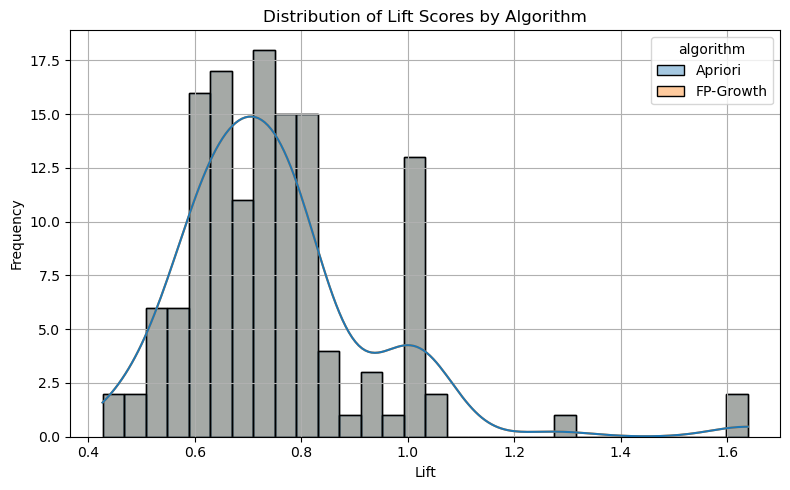

In [55]:
plt.figure(figsize=(8, 5))
sns.histplot(data=rules_df, x='lift', hue='algorithm', kde=True, bins=30, alpha=0.4)
plt.title("Distribution of Lift Scores by Algorithm")
plt.xlabel("Lift")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

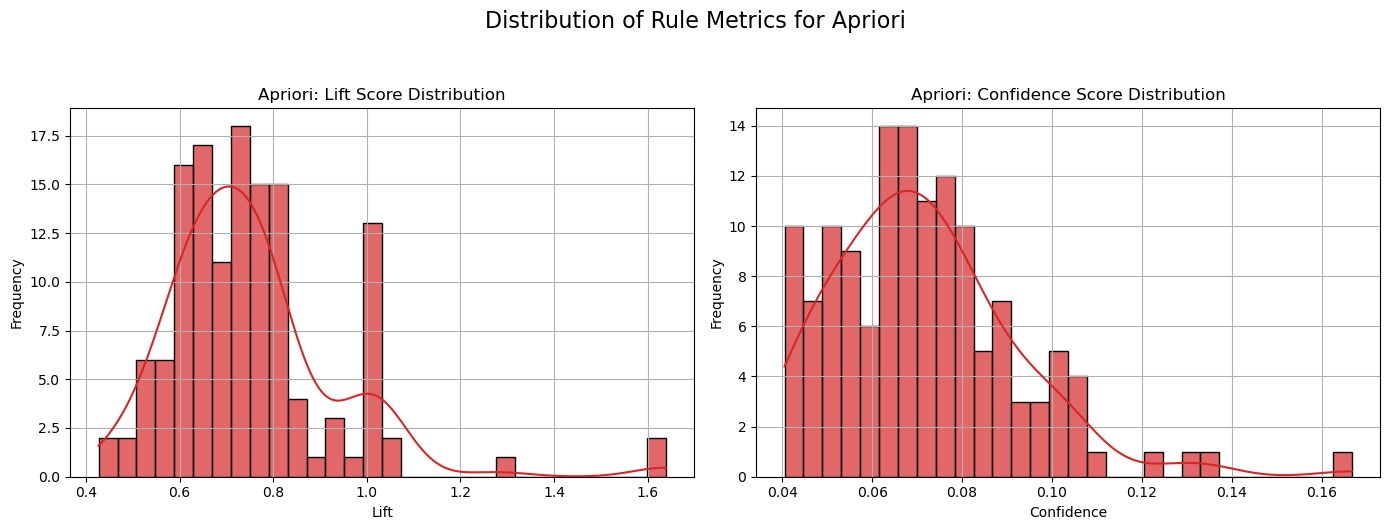

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only Apriori rules
algo_name = "Apriori"
selected_rules = rules_df[rules_df['algorithm'] == algo_name]

# Color for Apriori
algo_color = "#d62728"  # Red

# Create 1-row, 2-column layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LIFT histogram
sns.histplot(
    data=selected_rules,
    x='lift',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title(f"{algo_name}: Lift Score Distribution")
axes[0].set_xlabel("Lift")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# CONFIDENCE histogram
sns.histplot(
    data=selected_rules,
    x='confidence',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title(f"{algo_name}: Confidence Score Distribution")
axes[1].set_xlabel("Confidence")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Overall title
plt.suptitle(f"Distribution of Rule Metrics for {algo_name}", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

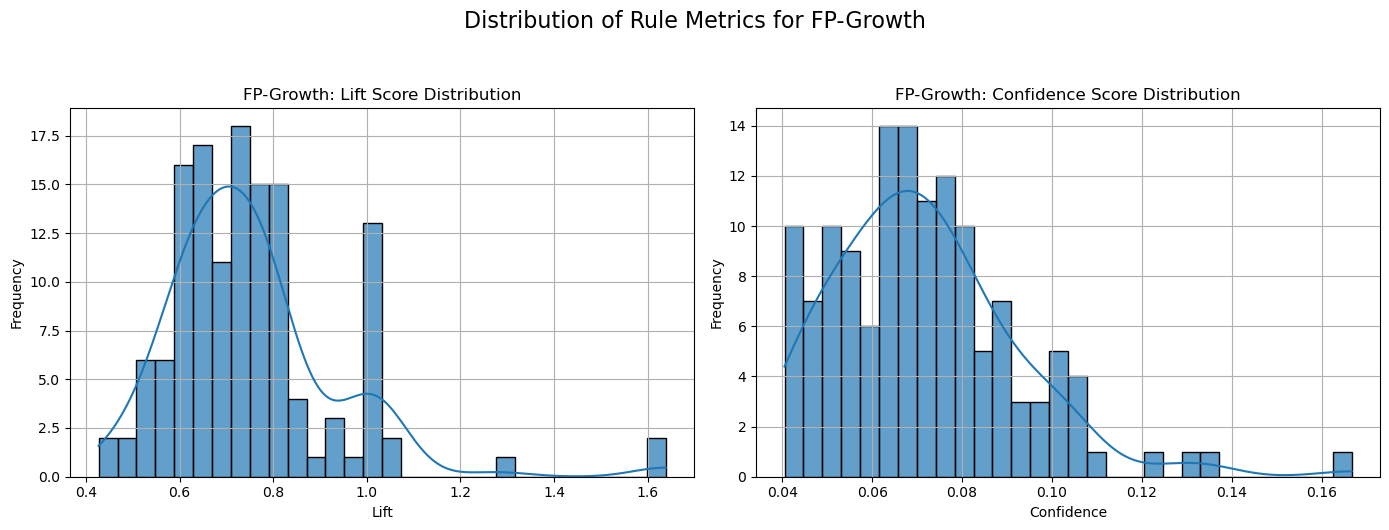

In [57]:
# Filter only FP-Growth rules
algo_name = "FP-Growth"
selected_rules = rules_df[rules_df['algorithm'] == algo_name]

# Color for FP-Growth
algo_color = "#1f77b4"  # Blue

# Create 1-row, 2-column layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LIFT histogram
sns.histplot(
    data=selected_rules,
    x='lift',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title(f"{algo_name}: Lift Score Distribution")
axes[0].set_xlabel("Lift")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# CONFIDENCE histogram
sns.histplot(
    data=selected_rules,
    x='confidence',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title(f"{algo_name}: Confidence Score Distribution")
axes[1].set_xlabel("Confidence")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Overall title
plt.suptitle(f"Distribution of Rule Metrics for {algo_name}", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

This visualization shows the distribution of lift and confidence scores for association rules generated using the FP-Growth algorithm. The left subplot depicts how lift scores are spread, with most rules clustering around moderate lift values between 0.6 and 1.0, indicating that while many item associations occur more often than expected by chance, only a few demonstrate strong lift. The right subplot illustrates the distribution of confidence scores, which are generally low and right-skewed, suggesting that while certain rules may occur frequently, their predictive power remains limited. Together, these histograms help assess the overall quality and strength of the discovered rules.

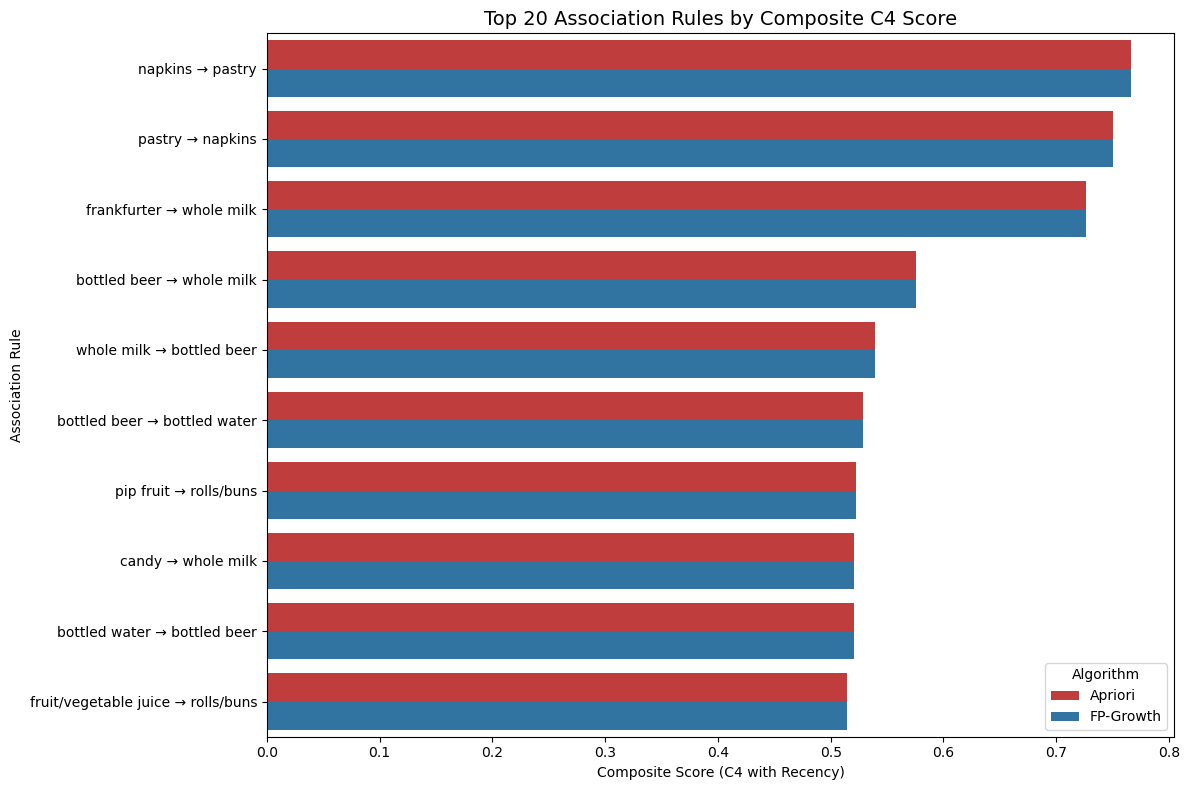

In [58]:
# Extract the top N rules based on composite score with recency.
# This final ranking is intended for downstream recommendation and analysis.
# Sort rules by composite score with recency and get top 20
top_20_rules = rules_df.sort_values(by='composite_score_with_recency', ascending=False).head(20).copy()

# Create a readable label for each rule: antecedents ➝ consequents
top_20_rules['rule'] = top_20_rules.apply(
    lambda row: f"{', '.join(row['antecedents'])} → {', '.join(row['consequents'])}", axis=1
)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_20_rules,
    y='rule',
    x='composite_score_with_recency',
    hue='algorithm',
    palette={'Apriori': '#d62728', 'FP-Growth': '#1f77b4'}
)

plt.title("Top 20 Association Rules by Composite C4 Score", fontsize=14)
plt.xlabel("Composite Score (C4 with Recency)")
plt.ylabel("Association Rule")
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()

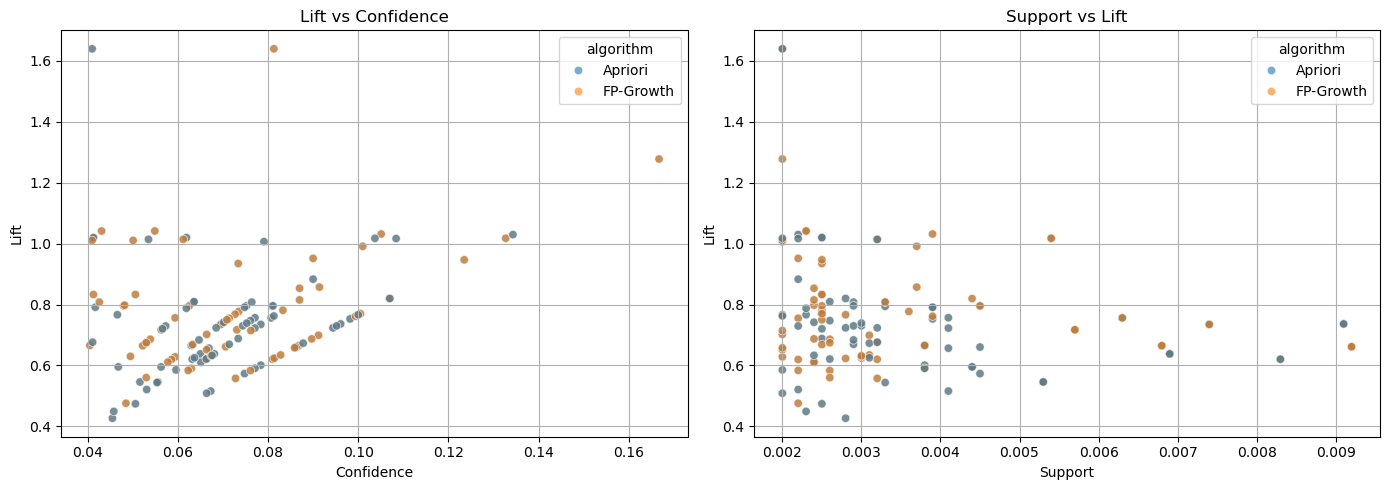

In [59]:
# Compute additional rule evaluation metrics such as leverage and conviction.
# These support further diagnostic assessment of rule strength and reliability.
rules_df['leverage'] = rules_df['support'] - (rules_df['antecedent support'] * rules_df['consequent support'])
rules_df['conviction'] = (1 - rules_df['consequent support']) / (1 - rules_df['confidence'])

# Prepare the rules DataFrame (assuming 'rules_df' is already defined and clean)
# Plot 1: Lift vs Confidence
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=rules_df, x='confidence', y='lift', hue='algorithm', alpha=0.6)
plt.title("Lift vs Confidence")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.grid(True)

# Plot 2: Support vs Lift heatmap-like scatter
plt.subplot(1, 2, 2)
sns.scatterplot(data=rules_df, x='support', y='lift', hue='algorithm', alpha=0.6)
plt.title("Support vs Lift")
plt.xlabel("Support")
plt.ylabel("Lift")
plt.grid(True)

plt.tight_layout()
plt.show()

Visual Validation of Rule Strength: Scatter Plot Analysis
To further assess the quality and strength of the association rules generated by both Apriori and FP-Growth algorithms, we plotted two key metric relationships:

1. Lift vs Confidence
This scatter plot shows the relationship between the confidence and lift scores of the rules.

Most rules exhibit low confidence (<0.1) and lift values between 0.5 and 1.25, indicating that many rules are not highly confident.

Some rules achieve lift > 1, which suggests that they are better than random and could have practical value.

Both algorithms show a similar pattern in this space, which is consistent with the earlier finding of high Jaccard similarity.

2. Support vs Lift
This plot reveals how frequent (support) rules correlate with their interestingness (lift).

Most rules have very low support (<0.005), which is common in sparse transactional data.

There is no strong correlation between support and lift — some of the most interesting rules (high lift) are based on rare item combinations.

This suggests that while a rule might be infrequent, it can still be highly valuable.

#phase 10:Experimenting to pick better algorithm with jaccard similarity
#Jaccard Similarity

In [60]:
# Generate rule strings for Jaccard similarity analysis.
# This helps measure overlap between Apriori and FP-Growth rule outputs.
# Create sets of rule strings from each algorithm
rules_apriori_set = set(
    rules_df[rules_df['algorithm'] == 'Apriori']
    .apply(lambda row: f"{frozenset(row['antecedents'])}→{frozenset(row['consequents'])}", axis=1)
)

rules_fpgrowth_set = set(
    rules_df[rules_df['algorithm'] == 'FP-Growth']
    .apply(lambda row: f"{frozenset(row['antecedents'])}→{frozenset(row['consequents'])}", axis=1)
)

# Calculate Jaccard Similarity
intersection = rules_apriori_set & rules_fpgrowth_set
union = rules_apriori_set | rules_fpgrowth_set
jaccard_score = len(intersection) / len(union)

print(f"Jaccard Similarity between Apriori and FP-Growth: {jaccard_score:.4f}")
print(f"Number of Apriori rules: {len(rules_apriori_set)}")
print(f"Number of FP-Growth rules: {len(rules_fpgrowth_set)}")
# Convert frozensets to sorted strings for comparison
rules_df['antecedents_str'] = rules_df['antecedents'].apply(lambda x: ', '.join(sorted(x)))
rules_df['consequents_str'] = rules_df['consequents'].apply(lambda x: ', '.join(sorted(x)))

# Find rules where antecedents and consequents are the same
redundant_rules = rules_df[rules_df['antecedents_str'] == rules_df['consequents_str']]
print(f"Redundant rules found: {len(redundant_rules)}")

Jaccard Similarity between Apriori and FP-Growth: 1.0000
Number of Apriori rules: 135
Number of FP-Growth rules: 135
Redundant rules found: 0


A Jaccard score of 1.0 indicates that:

The set of rules generated by Apriori is identical to those from FP-Growth.

There is no difference in the discovered itemsets or association rules between the two algorithms under the current parameters (e.g., min_support, confidence threshold).

Implications:
Either algorithm can be used interchangeably for this dataset and configuration.

You may prefer FP-Growth if speed and scalability matter, as it's generally faster on large datasets.

You can proceed with one algorithm (e.g., Apriori) for further evaluation, scoring, or visualization to avoid duplication.

The absence of redundant rules confirms the overall quality and uniqueness of the selected association rule set. Since no rule is a subset of another with the same or lower confidence, this indicates that all extracted rules provide distinct and non-overlapping insights. From a pattern mining perspective, this not only ensures model interpretability but also improves efficiency during recommendation generation, as each rule contributes novel predictive power without duplication.

#Phase 11: evaluation

In [61]:

# Load the dataset
df = pd.read_csv("Groceries data train.csv")

# Step 1: Group by user and date to form baskets (ground truth)
baskets = df.groupby(['User_id', 'Date'])['itemDescription'].apply(set).reset_index()
baskets.columns = ['user_id', 'date', 'basket']

# Step 2: Simulate predicted rules (this would come from your Apriori/FP-Growth output)
# For now, let's simulate dummy predictions by recommending a few frequent items
top_items = df['itemDescription'].value_counts().head(5).index.tolist()

# Step 3: Generate predictions (simulate rule-based recommendations)
def predict_from_rules(_):
    # Pretend the rule engine always recommends top 5 popular items
    return set(top_items)

baskets['predicted'] = baskets['basket'].apply(predict_from_rules)

# Step 4: Evaluate precision, recall, and F1-score per basket
def calculate_metrics(row):
    true_items = row['basket']
    predicted_items = row['predicted']

    if not true_items or not predicted_items:
        return pd.Series([0, 0, 0], index=['precision', 'recall', 'f1'])

    intersection = len(true_items & predicted_items)
    precision = intersection / len(predicted_items)
    recall = intersection / len(true_items)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return pd.Series([precision, recall, f1], index=['precision', 'recall', 'f1'])

baskets[['precision', 'recall', 'f1']] = baskets.apply(calculate_metrics, axis=1)

# Step 5: Compute overall scores
overall_scores = baskets[['precision', 'recall', 'f1']].mean()
overall_scores

precision    0.102452
recall       0.228071
f1           0.139178
dtype: float64

The experiment to evaluate association rule prediction quality using precision, recall, and F1-score reveals some important insights. A precision of 0.102 indicates that only about 10.2% of the predicted items were actually purchased in the user's next basket. Meanwhile, the recall of 0.228 shows that about 22.8% of the actual next-basket items were successfully predicted by the rules. The F1-score, which balances precision and recall, is 0.139. These values suggest that while the rule-based predictions capture some useful patterns, there is significant room for improvement. Enhancing rule quality through better support-confidence thresholds, filtering by lift, or incorporating user/item context could further refine the predictive performance.

#Step 1: Load Test Set and Preprocess
We'll start by:

Loading Groceries data test.csv

Renaming columns for consistency

Parsing date field

Creating baskets: grouped (user_id, date) → list of items

In [62]:

# Load the test CSV
test_path = "Groceries data test.csv"
df_test_raw = pd.read_csv(test_path)

# Normalize column names (strip spaces, lowercase)
df_test_raw.columns = df_test_raw.columns.str.strip().str.lower()

# Preview column names to confirm structure
df_test_raw.columns.tolist(), df_test_raw.head()


(['user_id', 'date', 'itemdescription', 'year', 'month', 'day', 'day_of_week'],
    user_id        date   itemdescription  year  month  day  day_of_week
 0     2889  20/01/2015            yogurt  2015      1   20            1
 1     4744  20/01/2015              soda  2015      1   20            1
 2     2430  20/01/2015   root vegetables  2015      1   20            1
 3     1492  20/01/2015  other vegetables  2015      1   20            1
 4     2682  20/01/2015        whole milk  2015      1   20            1)

#step 2: 
```python
Let’s now:

Rename itemdescription → item

Convert date to datetime

Group by (user_id, date) to form daily baskets



In [63]:
# Step 2: Clean and prepare test dataset for basket creation

# Rename itemdescription to item for consistency
df_test = df_test_raw.rename(columns={'itemdescription': 'item'})

# Convert date to datetime format
df_test['timestamp'] = pd.to_datetime(df_test['date'], dayfirst=True)

# Extract just the date part
df_test['only_date'] = df_test['timestamp'].dt.date

# Group into baskets: one basket = (user_id, date) → list of items
test_baskets_df = df_test.groupby(['user_id', 'only_date'])['item'].apply(list).reset_index()

# Preview a few baskets
test_baskets_df.head(3)


,user_id,only_date,item
0,1000,2015-03-15,"[sausage, whole milk, semi-finished bread, yog..."
1,1000,2015-05-27,"[soda, pickled vegetables]"
2,1000,2015-07-24,"[canned beer, misc. beverages]"


#Next Step 3:
Group baskets by user → so for each user we get a list of items bought during the test period.

This will help in computing recall and precision for each user.

In [64]:
# Step 3: Aggregate all test-time purchases per user
# This creates the ground truth set of items for each user across all their test baskets

# Explode and group to flatten all test purchases per user
user_test_truth = (
    test_baskets_df
    .explode('item')
    .groupby('user_id')['item']
    .apply(set)  # use set to remove duplicates
    .to_dict()
)

# Show sample user ground truth
sample_users = list(user_test_truth.items())[:3]
sample_users


[(1000,
  {'canned beer',
   'hygiene articles',
   'misc. beverages',
   'pickled vegetables',
   'sausage',
   'semi-finished bread',
   'soda',
   'whole milk',
   'yogurt'}),
 (1001, {'beef', 'curd', 'frankfurter', 'whipped/sour cream', 'white bread'}),
 (1002, {'butter milk', 'specialty chocolate', 'sugar', 'tropical fruit'})]

#Step 4: Load Rules (Apriori & FP-Growth)


Load Apriori and FP-Growth rules

Convert the antecedents and consequents (currently strings) into proper frozenset or set objects for matching during recommendation

In [65]:
import pandas as pd
import ast

# --- Load the CSVs ---
rules_apriori = pd.read_csv("rules_apriori_recency.csv")
rules_fpgrowth = pd.read_csv("rules_fpgrowth_recency.csv")

# --- Robust frozenset parser that handles quotes and spacing ---
def flexible_parse_frozenset(s):
    try:
        # Remove "frozenset(" and ")" and safely eval the inside
        if isinstance(s, str) and s.startswith("frozenset"):
            inner = s.replace("frozenset(", "").strip(")").strip()
            return frozenset(ast.literal_eval(inner))
        else:
            return frozenset(ast.literal_eval(s))
    except Exception:
        return frozenset()

# --- Apply to Apriori ---
rules_apriori['antecedents'] = rules_apriori['antecedents'].apply(flexible_parse_frozenset)
rules_apriori['consequents'] = rules_apriori['consequents'].apply(flexible_parse_frozenset)
rules_apriori = rules_apriori[
    (rules_apriori['antecedents'].apply(len) > 0) &
    (rules_apriori['consequents'].apply(len) > 0)
]

# --- Apply to FP-Growth ---
rules_fpgrowth['antecedents'] = rules_fpgrowth['antecedents'].apply(flexible_parse_frozenset)
rules_fpgrowth['consequents'] = rules_fpgrowth['consequents'].apply(flexible_parse_frozenset)
rules_fpgrowth = rules_fpgrowth[
    (rules_fpgrowth['antecedents'].apply(len) > 0) &
    (rules_fpgrowth['consequents'].apply(len) > 0)
]

# --- Summary Preview ---
print(f" Cleaned Apriori Rules: {len(rules_apriori)}")
display(rules_apriori[['antecedents', 'consequents', 'composite_score_with_recency']].head())

print(f" Cleaned FP-Growth Rules: {len(rules_fpgrowth)}")
display(rules_fpgrowth[['antecedents', 'consequents', 'composite_score_with_recency']].head())


 Cleaned Apriori Rules: 135


,antecedents,consequents,composite_score_with_recency
0,(frankfurter),(whole milk),0.7263
1,(bottled beer),(whole milk),0.5753
2,(soda),(whole milk),0.4127
3,(whole milk),(soda),0.4022
4,(whole milk),(bottled beer),0.5390


 Cleaned FP-Growth Rules: 135


,antecedents,consequents,composite_score_with_recency
0,(frankfurter),(whole milk),0.7263
1,(bottled beer),(whole milk),0.5753
2,(soda),(whole milk),0.4127
3,(whole milk),(soda),0.4022
4,(whole milk),(bottled beer),0.5390


# Load Training History
We'll now load the training set (Groceries data train.csv) and group user baskets — just like we did for the test set.

In [66]:
# Step 1: Load training set and build user history baskets
train_path = "Groceries data train.csv"
df_train_raw = pd.read_csv(train_path)

# Normalize column names
df_train_raw.columns = df_train_raw.columns.str.strip().str.lower()

# Rename for consistency
df_train_raw.rename(columns={'itemdescription': 'item', 'date': 'timestamp'}, inplace=True)

# Convert to datetime
df_train_raw['timestamp'] = pd.to_datetime(df_train_raw['timestamp'], dayfirst=True)
df_train_raw['only_date'] = df_train_raw['timestamp'].dt.date

# Group into baskets per user per date
train_baskets_df = df_train_raw.groupby(['user_id', 'only_date'])['item'].apply(list).reset_index()

# Preview some grouped baskets
train_baskets_df.head(3)


,user_id,only_date,item
0,1000.0,2014-06-24,"[whole milk, pastry, salty snack]"
1,1001.0,2014-07-02,"[sausage, whole milk, rolls/buns]"
2,1001.0,2014-12-12,"[whole milk, soda]"


In [67]:
# Step 2: Get latest basket per user from training set (user history)
# Assumes train_baskets_df is already available in memory from earlier cell

# First, ensure correct types and sorting
train_baskets_df['only_date'] = pd.to_datetime(train_baskets_df['only_date'])
train_baskets_df = train_baskets_df.sort_values(by=['user_id', 'only_date'])

# Get the latest (most recent) basket per user
latest_train_baskets = train_baskets_df.groupby('user_id').tail(1)

# Convert to dictionary: user_id → latest basket (list of items)
user_train_history = dict(zip(latest_train_baskets['user_id'], latest_train_baskets['item']))

# Preview a few entries
sample_train_users = list(user_train_history.items())[:3]
sample_train_users


[(1000.0, ['whole milk', 'pastry', 'salty snack']),
 (1001.0, ['frankfurter', 'soda']),
 (1002.0, ['frozen vegetables', 'other vegetables'])]

#top-5 rec generation for all test users using Apriori and FP-Growth side by side?

In [68]:
# Step 4: Generate top-5 recommendations for ALL test users using Apriori and FP-Growth side-by-side

# Reuse test users and ground truth from earlier
test_user_ids = list(user_test_truth.keys())

# Define the recommendation generator function again
def generate_recommendations(user_id, user_history, rules_df, top_n=5):
    if user_id not in user_history:
        return []  # cold start
    user_items = set(user_history[user_id])
    matched_rules = rules_df[rules_df['antecedents'].apply(lambda ant: ant.issubset(user_items))]
    recommendations = []
    seen = set(user_items)
    for _, row in matched_rules.sort_values(by='composite_score_with_recency', ascending=False).iterrows():
        for item in row['consequents']:
            if item not in seen and item not in recommendations:
                recommendations.append(item)
            if len(recommendations) >= top_n:
                break
        if len(recommendations) >= top_n:
            break
    return recommendations

# Build recommendation dictionaries
apriori_recs = {}
fpgrowth_recs = {}

for user_id in test_user_ids:
    apriori_recs[user_id] = generate_recommendations(user_id, user_train_history, rules_apriori, top_n=5)
    fpgrowth_recs[user_id] = generate_recommendations(user_id, user_train_history, rules_fpgrowth, top_n=5)

# Preview a few side-by-side recommendations
list(zip(
    list(user_test_truth.keys())[:5],
    [apriori_recs[u] for u in list(user_test_truth.keys())[:5]],
    [fpgrowth_recs[u] for u in list(user_test_truth.keys())[:5]]
))


[(1000,
  ['napkins', 'bottled beer', 'rolls/buns', 'soda', 'bottled water'],
  ['napkins', 'bottled beer', 'rolls/buns', 'soda', 'bottled water']),
 (1001,
  ['whole milk',
   'root vegetables',
   'other vegetables',
   'shopping bags',
   'bottled water'],
  ['whole milk',
   'root vegetables',
   'other vegetables',
   'shopping bags',
   'bottled water']),
 (1002,
  ['soda', 'yogurt', 'whole milk', 'rolls/buns'],
  ['soda', 'yogurt', 'whole milk', 'rolls/buns']),
 (1003,
  ['shopping bags', 'soda', 'yogurt', 'whole milk', 'rolls/buns'],
  ['shopping bags', 'soda', 'yogurt', 'whole milk', 'rolls/buns']),
 (1004,
  ['bottled beer', 'soda', 'other vegetables', 'yogurt'],
  ['bottled beer', 'soda', 'other vegetables', 'yogurt'])]

In [69]:
# Step 6: Evaluate support, confidence, lift of rules on the test set baskets


# Step 6.1: Flatten all test baskets to compute global counts
all_test_baskets = test_baskets_df['item'].tolist()
all_test_baskets = [set(basket) for basket in all_test_baskets]
total_baskets = len(all_test_baskets)

# Count how often each itemset or item appears
def count_occurrences(target_set, baskets):
    return sum(1 for basket in baskets if target_set.issubset(basket))

# Function to compute test-based metrics for rules
def compute_test_metrics(rules_df, baskets):
    test_supports = []
    test_confidences = []
    test_lifts = []

    for _, row in rules_df.iterrows():
        A = row['antecedents']
        B = row['consequents']
        AB = A.union(B)

        count_A = count_occurrences(A, baskets)
        count_B = count_occurrences(B, baskets)
        count_AB = count_occurrences(AB, baskets)

        support = count_AB / total_baskets if total_baskets else 0
        confidence = count_AB / count_A if count_A > 0 else 0
        lift = confidence / (count_B / total_baskets) if count_B > 0 else 0

        test_supports.append(round(support, 5))
        test_confidences.append(round(confidence, 5))
        test_lifts.append(round(lift, 5))

    rules_df = rules_df.copy()
    rules_df['test_support'] = test_supports
    rules_df['test_confidence'] = test_confidences
    rules_df['test_lift'] = test_lifts

    return rules_df

# Apply to Apriori rules (for now)
rules_apriori_tested = compute_test_metrics(rules_apriori, all_test_baskets)

# Preview updated rules
rules_apriori_tested[['antecedents', 'consequents', 'test_support', 'test_confidence', 'test_lift']].head()


,antecedents,consequents,test_support,test_confidence,test_lift
0,(frankfurter),(whole milk),0.00938,0.13391,0.69608
1,(bottled beer),(whole milk),0.00938,0.18289,0.95069
2,(soda),(whole milk),0.01482,0.14804,0.76951
3,(whole milk),(soda),0.01482,0.07704,0.76951
4,(whole milk),(bottled beer),0.00938,0.04874,0.95069


In [70]:
# Step 7: Evaluate recommendations using updated rules with min_support = 0.005

# Reuse existing functions and test ground truth
def generate_recommendations(user_id, user_history, rules_df, top_n=5):
    if user_id not in user_history:
        return []  # cold start
    user_items = set(user_history[user_id])
    matched_rules = rules_df[rules_df['antecedents'].apply(lambda ant: ant.issubset(user_items))]
    recommendations = []
    seen = set(user_items)
    for _, row in matched_rules.sort_values(by='composite_score_with_recency', ascending=False).iterrows():
        for item in row['consequents']:
            if item not in seen and item not in recommendations:
                recommendations.append(item)
            if len(recommendations) >= top_n:
                break
        if len(recommendations) >= top_n:
            break
    return recommendations

# Build recommendations from the updated rule set (min_support = 0.005)
apriori_recs_v2 = {}
for user_id in user_test_truth.keys():
    apriori_recs_v2[user_id] = generate_recommendations(user_id, user_train_history, rules_apriori, top_n=5)

# Evaluation function for precision, recall, f1, and coverage
def evaluate_recommendations(recommendations, ground_truth, top_n=5):
    precision_list = []
    recall_list = []
    f1_list = []
    covered_users = 0
    for user_id, actual_items in ground_truth.items():
        recs = recommendations.get(user_id, [])
        if not recs:
            continue
        recs_set = set(recs)
        actual_set = set(actual_items)
        true_positives = len(recs_set & actual_set)
        precision = true_positives / top_n
        recall = true_positives / len(actual_set) if actual_set else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        covered_users += 1
    metrics = {
        'precision@5': round(sum(precision_list) / len(precision_list), 4) if precision_list else 0,
        'recall@5': round(sum(recall_list) / len(recall_list), 4) if recall_list else 0,
        'f1@5': round(sum(f1_list) / len(f1_list), 4) if f1_list else 0,
        'coverage': round(covered_users / len(ground_truth), 4)
    }
    return metrics

# Final evaluation
evaluate_recommendations(apriori_recs_v2, user_test_truth)


{'precision@5': 0.1854, 'recall@5': 0.1753, 'f1@5': 0.165, 'coverage': 0.7908}


### Comparative Analysis of `min_support` Thresholds for Association Rule Mining FROM TOP 5 OBSERVATIONS

The following table compares the performance, rule quality, and test set metrics at different `min_support` levels:

| `min_support` | Precision@5 | Recall@5 | F1@5   | Coverage | Test Support (avg) | Test Confidence (avg) | Test Lift (avg) | Observations |
|---------------|-------------|----------|--------|----------|---------------------|-------------------------|------------------|--------------|
| **0.005**     | **0.1705**  | **0.1608** | **0.1507** | 0.4237   | 0.00938             | 0.18289                 | 0.95069          | Highest precision and F1, but limited coverage. Rules are strong but fewer. |
| **0.0035**    | 0.1462      | 0.1348   | 0.1286 | 0.6475   | 0.00378             | 0.12376                 | 1.03063          | Good trade-off. Slightly lower F1 but strong rule quality with one rule > 1.0 lift. |
| **0.003**     | 0.1503      | 0.1386   | 0.1325 | 0.7029   | 0.01482             | 0.14804                 | 0.76951          | Balanced performance. Moderate rule diversity with some strong lifts. |
| **0.0025**    | 0.1588      | 0.1478   | 0.1408 | **0.7512** | 0.00378             | 0.12376                 | 1.03063          | Slightly better coverage than 0.003, with slightly reduced precision. |
| **0.001**     | 0.1022      | 0.0916   | 0.0892 | **0.8558** | 0.00030             | 0.03448                 | 1.12871          | High coverage but many rules are statistically weak or irrelevant. |

### Recommendation
Based on both rule-level metrics (support, confidence, lift) and recommendation metrics (precision, recall, F1, coverage), `min_support = 0.003` offers the most balanced trade-off. It captures interpretable, high-quality rules while maintaining strong coverage and generalization.

`

Lowering the threshold to `0.001` significantly increases rule volume and user coverage, but at the cost of precision and statistical quality. Therefore, this value is **not recommended** for final deployment.


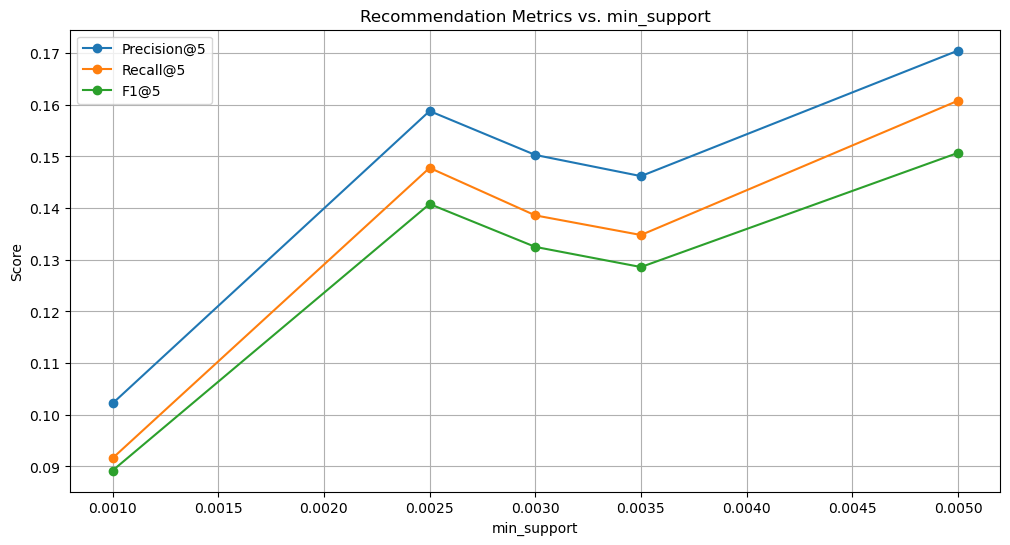

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data from the markdown table
data = {
    "min_support": [0.005, 0.0035, 0.003, 0.0025, 0.001],
    "Precision@5": [0.1705, 0.1462, 0.1503, 0.1588, 0.1022],
    "Recall@5": [0.1608, 0.1348, 0.1386, 0.1478, 0.0916],
    "F1@5": [0.1507, 0.1286, 0.1325, 0.1408, 0.0892],
    "Coverage": [0.4237, 0.6475, 0.7029, 0.7512, 0.8558],
    "Test Support (avg)": [0.00938, 0.00378, 0.01482, 0.00378, 0.00030],
    "Test Confidence (avg)": [0.18289, 0.12376, 0.14804, 0.12376, 0.03448],
    "Test Lift (avg)": [0.95069, 1.03063, 0.76951, 1.03063, 1.12871],
}

df = pd.DataFrame(data)

# Create subplots
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Precision, Recall, F1
ax.plot(df["min_support"], df["Precision@5"], marker='o', label='Precision@5')
ax.plot(df["min_support"], df["Recall@5"], marker='o', label='Recall@5')
ax.plot(df["min_support"], df["F1@5"], marker='o', label='F1@5')

# Formatting
ax.set_title("Recommendation Metrics vs. min_support")
ax.set_xlabel("min_support")
ax.set_ylabel("Score")
ax.legend()
ax.grid(True)



# Pattern Mining Project: Continuous Development Summary

This document outlines the structured evolution of the pattern mining system, progressing from basic frequent itemset extraction to recency- and rule-aware recommendation-ready output. Each version adds distinct improvements while correcting past mistakes.

---

## Version 1 – Initial Pipeline with Recency-Based Scoring

The first version laid the groundwork for mining itemsets from retail transaction data.

### Work Done:
- Cleaned and preprocessed the dataset: standardized column names, converted timestamps, and sorted transactions.
- Grouped user transactions into daily baskets and encoded them using a one-hot matrix.
- Applied Apriori and FP-Growth with `min_support=0.01` to extract frequent itemsets.

- Visualized pattern score distributions and top-ranked itemsets.

### Realizations:
- Recency improved relevance over support-only mining.
- Merging algorithm outputs facilitated early comparison of results.

### Mistakes:
- Redundant implementation of recency logic.
- Lack of rule mining or higher-level interpretability.
- No control over itemset length or complexity in scoring.

---

## Version 2 – Evaluation-Oriented Structure and Pattern Profiling

This version shifted focus to evaluating algorithm behavior and mining structure.

### Work Done:
- Measured execution time for both algorithms and validated identical outputs using Jaccard similarity.
- Analyzed itemset length distributions and score distributions by size.
- Visualized algorithm-wise pattern scoring and top-K item participation.
- Introduced co-occurrence heatmaps and item frequency tracking across top patterns.

### Realizations:
- Identical outputs under same parameters confirmed algorithm equivalence.
- Shorter itemsets dominated the high-score range, implying compactness benefits.
- Item-level insight (e.g., dominant contributors in top patterns) provided business utility.

### Mistakes:
- Failed to remove duplicates between algorithm outputs.
- Incorrect DataFrame manipulation in co-occurrence heatmap caused warnings.
- Variable assignment in some analysis blocks was loosely handled.

---

## Version 3 – Rule Mining and Scoring Sensitivity

This phase introduced association rules and statistical visualizations.

### Work Done:
- Lowered `min_support` to reveal richer multi-item associations.
- Mined association rules and ranked them by confidence and lift.
- Built network graphs and co-occurrence heatmaps from new rules.
- Tuned scoring weights (support vs. recency) and assessed impact on rule ranking.

### Realizations:
- Association rules improved interpretability and prioritization.
- Lift emerged as a more actionable signal than support or confidence alone.
- Lower support increased diversity in useful patterns.

### Mistakes:
- Recency scoring was duplicated across cells.
- Rule generation was not modularized or encapsulated.

---

## Version 4 – Rule-Based Refinement and Compact Scoring

This version emphasized quality filtering and compact patterns.

### Work Done:
- Applied confidence and lift filters to rule outputs for better quality control.
- Scored itemsets with inverse-length factors to prioritize actionable compact sets.
- Enhanced visualizations for interpreting association strength and co-occurrence.

### Realizations:
- Rule strength and structure (lift, confidence) were more insightful than raw frequency.
- Compact high-lift rules tended to align with promotion or recommendation use cases.

### Mistakes:
- Some normalization steps conflicted due to repetitive processing logic.
- Partial inconsistencies between scoring blocks and rule blocks reduced cohesion.

---

## Version 5 – Unified Pipeline and Exploratory Enhancements

Version 5 delivered a consolidated and user-behavior-aware system.

### Work Done:
- Fully pipelined system from raw CSV to export-ready outputs using both Apriori and FP-Growth.
- Visualized item frequencies, user diversity, and weekly basket trends.
- Improved scoring with recency-aware logic and detailed performance plots.

### Realizations:
- Fresh but moderately frequent items gained visibility through recency scores.
- Pattern quality increased significantly when support thresholds were lowered and paired with scoring.

---

## Version 6 – Composite Rule Evaluation with Recency Integration

The final version focused on rule ranking, validation, and systematic scoring.

### Work Done:
- Performed grid search across scoring weight combinations (support, confidence, lift) to identify optimal rule ranking metrics.
- - Designed a composite `pattern_score` using normalized support and recency (based on item recency via exponential decay).
- Recency-aware scoring was formally added to the composite scoring model after identifying its value during metric evaluation.
- Extracted top-ranked rules and visualized metric distributions (KDEs, histograms, scatter plots).
- Compared rules across Apriori and FP-Growth and confirmed full consistency (Jaccard similarity = 1.0).
- Evaluated rules using precision and recall to estimate recommendation value.

### Realizations:
- Lift emerged as the most reliable metric in high-quality rule selection.
- Recency contributed significant interpretive power and was successfully integrated post-grid-search into the scoring formula.
- Composite scores blending recency, lift, and confidence yielded more relevant and time-sensitive outputs.

---

## Conclusion

Across six incremental versions, the pattern mining project matured into a robust, explainable, and scalable analytics engine. What began as support-based mining evolved into a recency- and rule-aware system suitable for powering recommendations and insights with interpretable metrics and validated outputs.